# Cats and Dogs Classification
<h4> Deep Learning With ANN </h4>

### 1. Packages 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import pwd
import copy
import h5py


### 2. Preprocessing Data

#### Load data

In [3]:
# copy path
data_folder = '/Users/minhquang/Documents/Learning/AI/data/kagglecatsanddogs_5340/PetImages'

In [4]:
os.listdir(data_folder)

['Cat', '.DS_Store', 'Dog']

In [5]:
def load_image_lazy(data_folder, target_size=(128, 128)):
    '''
    data_folder: folder contains all of dataset
    -return: images (array), labels
    target_size: fixed size for all images
    '''
    for label in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, label) # take directory of each label
        
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                try:
                    with Image.open(file_path) as img:
                        img = img.convert('RGB')
                        img = img.resize(target_size)
                        img_array = np.asarray(img)
                        yield img_array, label
                except Exception as e:
                    print(f"Can't process the file image: {e}")
                    

In [6]:
def load_data(data_folder):
    X, y = [], []
    count_label = 0
    classes = {}
    for img_array, label in load_image_lazy(data_folder):
        yi = None
        X.append(img_array)
        if label not in classes:
            classes[label] = count_label
            count_label += 1
        y.append(classes[label])
    return np.array(X), np.array(y), classes

In [7]:
X_orig, y_orig, classes = load_data(data_folder)

Can't process the file image: cannot identify image file '/Users/minhquang/Documents/Learning/AI/data/kagglecatsanddogs_5340/PetImages/Cat/Thumbs.db'
Can't process the file image: cannot identify image file '/Users/minhquang/Documents/Learning/AI/data/kagglecatsanddogs_5340/PetImages/Cat/666.jpg'


/Users/minhquang/Documents/Learning/AI/py3.10.venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Can't process the file image: cannot identify image file '/Users/minhquang/Documents/Learning/AI/data/kagglecatsanddogs_5340/PetImages/Dog/Thumbs.db'
Can't process the file image: cannot identify image file '/Users/minhquang/Documents/Learning/AI/data/kagglecatsanddogs_5340/PetImages/Dog/11702.jpg'


In [8]:
print("X_orig shape:", X_orig.shape)
print("y_orig shape:", y_orig.shape)
print("Classes mapping:", classes)

X_orig shape: (24998, 128, 128, 3)
y_orig shape: (24998,)
Classes mapping: {'Cat': 0, 'Dog': 1}


#### Process data

In [9]:
X_standardize = X_orig/255.
X = X_standardize.reshape(X_standardize.shape[0], -1).T
y = y_orig.reshape(1, -1)

In [10]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (49152, 24998)
y shape: (1, 24998)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, train_size=0.8)

In [12]:
print(y_train.T[:, :2000].shape)
print(X_train.T[:, :2000].shape)

(1, 2000)
(49152, 2000)


### 3. ANN Model

#### 3.1. Helper functions

In [13]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

In [14]:
def tanh(Z):
    A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    cache = Z
    return A, cache

In [15]:
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

In [16]:
def relu_backward(dA, cache):
    Z = cache
    dZ = copy.deepcopy(dA)
    dZ[Z <= 0] = 0
    return dZ

In [17]:
def sigmoid_backward(dA, cache):
    Z = cache
    A, _ = sigmoid(Z)
    dZ = dA * A * (1 - A)
    return dZ

In [18]:
def tanh_backward(dA, cache):
    Z = cache
    A, _ = tanh(Z)
    dZ = dA * (1 - A**2)
    return dZ

#### 3.2. Main functions

##### 3.2.1. Initialize parameters

In [19]:
def initialize_parameters(layers_dims):
    ''' 
    initialize weights and bias for nn
    layers_dims: a list of size (quantity of units) of each layers. Example: [5, 4, 3, 2, 1]: 5 -> features X 
    return: dict of parameters
    '''
    np.random.seed(52)
    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        # degbug
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))
    return parameters

##### 3.2.2. Forward Propagation

In [20]:
def linear_forward(A_prev, W, b):
    Z = W @ A_prev + b 
    cache = (A_prev, W, b)
    return Z, cache

In [21]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == 'relu':
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    elif activation == 'tanh':
        A, activation_cache = tanh(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

In [22]:
def L_model_forward(X, parameters):
    caches = []
    A_prev = X
    L = len(parameters) // 2
    for l in range(L - 1): # (linear->relu) * (L-1) -> (linear->sigmoid)
        A_prev, cache = linear_activation_forward(A_prev, parameters['W' + str(l+1)], parameters['b' + str(l+1)], activation='relu')
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A_prev, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    return AL, caches

### 3.2.3. Cost Computation

In [23]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    AL = np.clip(AL, 1e-15, 1 - 1e-15) # avoid equal to 0
    cost = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)
    return cost

### 3.2.4. Backward Propagation

In [24]:
def linear_backward(dZ, cache):
    m = dZ.shape[1]
    A_prev, W, b = cache
    
    dW = (1/m) * (dZ @ A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T @ dZ
    return dW, db, dA_prev

In [25]:
def linear_activation_backward(dA, cache, activation):
    (linear_cache, activation_cache) = cache
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
    elif activation == 'tanh':
        dZ = tanh_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [30]:
def L_model_backward(AL, Y, caches):
    L = len(caches)
    m = Y.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL + 1e-8) - np.divide(1 - Y, (1 - AL) + 1e-8))
    grads = {}
    
    dA_prev, dW, db = linear_activation_backward(dAL, caches[L-1], activation='sigmoid')
    grads['dW' + str(L)] = dW
    grads['db' + str(L)] = db
    
    for l in reversed(range(L - 1)):
        dA_prev, dW, db = linear_activation_backward(dA_prev, caches[l], activation='relu')
        grads['dW' + str(l + 1)] = dW
        grads['db' + str(l + 1)] = db
    return grads
    

### 3.2.5. Update Parameters

In [27]:
def update_parameters(parameters, grads, learning_rate=1e-3):
    params = copy.deepcopy(parameters)
    L = len(parameters) // 2
    for l in range (L):
        params["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        params["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]
    return params

### 3.3. ANN Model

In [ ]:
def create_mini_batches(X, Y, mini_batch_size):
    m = X.shape[1]  
    mini_batches = []
    
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    num_complete_minibatches = m // mini_batch_size
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size :]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False, decay_rate=0.9, mini_batch_size=128):
    costs = []
    parameters = initialize_parameters(layers_dims)
    
    for i in range(num_iterations):
        mini_batches = create_mini_batches(X, Y, mini_batch_size)
        for mini_batch in mini_batches:
            (mini_batch_X, mini_batch_Y) = mini_batch
            AL, caches = L_model_forward(mini_batch_X, parameters)
            cost = compute_cost(AL, mini_batch_Y)
            grads = L_model_backward(AL, mini_batch_Y, caches)
            parameters = update_parameters(parameters, grads, learning_rate)
            
        if i % 100 == 0:
            learning_rate *= decay_rate
        
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print(f"Cost after iteration {i}: {np.squeeze(cost)}")
            costs.append(cost)
    
    return parameters, costs
def predict(X, parameters, threshold=0.5):
    AL, caches = L_model_forward(X, parameters)
    predictions = (AL > threshold)
    return predictions

def score(X, y, parameters):
    predictions = predict(X, parameters)
    accuracy = 100 * np.mean(predictions == y) 
    return accuracy

def plot_costs(costs):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iteration')
    plt.title("Cost Plot")
    plt.show()

## Training

Cost after iteration 0: 0.6878578266871258
Cost after iteration 100: 0.39381274123048904
Cost after iteration 200: 0.5085968212077283
Cost after iteration 300: 0.3036148446086908
Cost after iteration 400: 0.06484251998648624
Cost after iteration 500: 0.0004900815583392972


/var/folders/70/d3kd_ryx2t11f9844q1jv12w0000gn/T/ipykernel_21424/1746190846.py:3: RuntimeWarning: divide by zero encountered in log
  cost = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
/var/folders/70/d3kd_ryx2t11f9844q1jv12w0000gn/T/ipykernel_21424/1746190846.py:3: RuntimeWarning: invalid value encountered in multiply
  cost = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))


Cost after iteration 600: 1.1270286453267445e-05
Cost after iteration 700: 9.805965267997337e-05
Cost after iteration 800: 4.567011388407454e-06
Cost after iteration 900: nan
Cost after iteration 999: nan


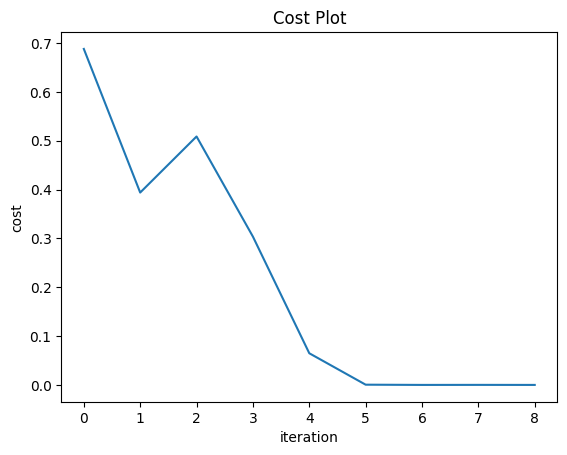

In [32]:
layers_dims = [X_train.T.shape[0], 512, 256, 16, 1]
parameters, costs = L_layer_model(X_train.T[:, :2000], y_train.T[:, :2000], num_iterations=1000, learning_rate=0.1, layers_dims=layers_dims, print_cost=True, decay_rate=0.9, mini_batch_size=64)
plot_costs(costs)

In [36]:
score(X_train.T[:, :2000], y_train.T[:, :2000], parameters)

np.float64(100.0)

In [37]:
score(X_test.T, y_test.T, parameters)


np.float64(60.06)

=> Overfitting: Can resolve by Regulization